##Modified Ibbotson (2014) Liquidity Strategy Adapted to Brazilian Stock Market
####The main goal of this notebook is to adapt and backtest one of the strategies present on **Ernest P. Chan´s Machine Trading** book to the brazilian´s stock market reality. The backtest steps are given as follows:  
#####**1. Method**
  1.1 - Fetch 1 year (from Jan, 01 2020 to Dec, 31 2020) of data for each of the stocks that participate on Ibovespa Index. Yahoo Finance was the data source used in the present notebook.

  1.2 - Preprocess data and model a suitable dataframe for this particular analysis.

  1.3 - Calcule SMA21 from Volume for each stock during all the given period.

  1.4 - Sort stocks daily based on ascending Date and descending value of **vol-sma**, a new column taken as the difference between Volume($t$) and it´s SMA21($t$)

  1.5 - Buy top 5 stocks with the highest vol-sma value on closing price at a day $t$ and short the same five stocks on closing prices at $t+1$

  1.6 - Short top 5 stocks with the lowest vol-sma value on closing price at a day $t$ and buy the same five stocks on closing prices at $t+1$

  1.7 - Steps 1.5 and 1.6 were repeated recursively during the analysis period


#####**2. Possible limitations of the present analysis**  
  2.1 - Survivorship Bias: This problem was partially adressed by reducing the backtest period and thus controlling the Ibovespa Index changing effects.  

  2.2 - One can hardly (pratically, never) buy at closing prices: This problem must be solved by adding a penalty term, whenever there is a buy/sell action, as a random number ranging between $0  -> + .01$ or a fixed number. Of course there are more sofisticated ways to deal with slippage costs. The random number can be sampled from a normal or an uniform distribution.

  2.3 - Transaction costs are broadly variable: This costs vary depending on the brokerage service. Therefore, a strategy may deliver alpha with a brokerage and performs worse than a passive investing with another. Be very careful when considering a strategy and always take into account transaction costs. I did not consider a transaction cost in this backtest, as the model presented a bad Equity Curve (at least for me).  

  2.4 - Stop Loss: As this is a Long and Short strategy based on liquidity, I decided to not include a stop loss constraint to the model, keeping in mind that the it can strongly influence Equity Curve during the backtest period.

#####**3. Interesting Results to keep in mind**  
  3.1 - Slippage costs and order collocation can make a huge impact on a quantitative trading model performance. Just look at the final graph and take your conclusions. One must never disregard them when evaluating a model.


In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as web
import warnings

warnings.filterwarnings('ignore')
matplotlib.rc("savefig", dpi=100)
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# Ibovespa Index stock´s composition by the time of 2021 March.
stocks_list = ['ABEV3',
 'ALPA4',
 'B3SA3',
 'BBAS3',
 'BBDC3',
 'BBDC4',
 'BBSE3',
 'BPAC11',
 'BRAP4',
 'BRFS3',
 'BRKM5',
 'BTOW3',
 'CCRO3',
 'CMIG3',
 'CMIG4',
 'CPFE3',
 'CPLE6',
 'CRFB3',
 'CSAN3',
 'CSNA3',
 'EGIE3',
 'ELET3',
 'ELET6',
 'ENGI11',
 'EQTL3',
 'GGBR4',
 'GNDI3',
 'HAPV3',
 'HYPE3',
 'ITSA4',
 'ITUB3',
 'ITUB4',
 'JBSS3',
 'KLBN11',
 'LAME3',
 'LAME4',
 'LREN3',
 'MGLU3',
 'NEOE3',
 'NTCO3',
 'PETR3',
 'PETR4',
 'PSSA3',
 'RADL3',
 'RAIL3',
 'RENT3',
 'SANB11',
 'SBSP3',
 'SULA11',
 'SUZB3',
 'TIMS3',
 'TOTS3',
 'TRPL4',
 'UGPA3',
 'VALE3',
 'VIVT3',
 'WEGE3']

In [3]:
# Yahoo finance codes are displayed with .SA at the end of the ticker
stocks = []
for i in stocks_list:
  stocks.append(i+'.SA')

In [4]:
# 1 year analysis period
start_date = '2020-01-01'
end_date = '2021-01-01'

# Use pandas_reader.data.DataReader to load the desired data.
panel_data = web.DataReader(stocks, 'yahoo', start_date, end_date)

In [5]:
panel_data.drop(['Open', 'High', 'Low', 'Close'], axis = 1, inplace = True)
panel_data.head()

Attributes  Adj Close                        ...      Volume                    
Symbols      ABEV3.SA   ALPA4.SA   B3SA3.SA  ...    VALE3.SA VIVT3.SA   WEGE3.SA
Date                                         ...                                
2020-01-02  18.616690  32.529774  43.622253  ...  17509700.0  38100.0  2938000.0
2020-01-03  18.354891  32.529774  42.365135  ...  17284800.0  49900.0  3672900.0
2020-01-06  18.442158  32.020557  41.958981  ...  32787800.0  43700.0  3183300.0
2020-01-07  18.480942  32.749432  43.312805  ...  16326400.0  46400.0  3151800.0
2020-01-08  18.393677  33.108875  43.196762  ...  15298500.0  47800.0  4076900.0

[5 rows x 114 columns]

In [6]:
stocks_dataframe = panel_data.stack() # Stack dataframe in multi indexes

In [7]:
stocks_dataframe.head(5)

Attributes           Adj Close      Volume
Date       Symbols                        
2020-01-02 ABEV3.SA  18.616690  16011300.0
           ALPA4.SA  32.529774   1355800.0
           B3SA3.SA  43.622253  19968600.0
           BBAS3.SA  50.686829  13159900.0
           BBDC3.SA  31.260302   3102110.0

In [8]:
stocks_dataframe.index.get_level_values(1) # 0, date (first level index), 1, tickers (second level index)

Index(['ABEV3.SA', 'ALPA4.SA', 'B3SA3.SA', 'BBAS3.SA', 'BBDC3.SA', 'BBDC4.SA',
       'BBSE3.SA', 'BPAC11.SA', 'BRAP4.SA', 'BRFS3.SA',
       ...
       'SANB11.SA', 'SBSP3.SA', 'SULA11.SA', 'SUZB3.SA', 'TOTS3.SA',
       'TRPL4.SA', 'UGPA3.SA', 'VALE3.SA', 'VIVT3.SA', 'WEGE3.SA'],
      dtype='object', name='Symbols', length=13833)

In [9]:
# number of stocks on the list is the same as the number of unique tickers on dataframe
stocks_dataframe.index.get_level_values(1).nunique(), len(stocks)

(57, 57)

In [10]:
stocks_dataframe['SMA_Volume'] = 0 # Start a blank SMA volume column to overwrite after

In [11]:
# For each stock i in list of stocks, overwrite the SMA Volume column by the rolling 21days mean of the same stock´s last volume´s.
for i in stocks:
  stocks_dataframe.loc[((stocks_dataframe.index.get_level_values(0)), i), 'SMA_Volume'] = stocks_dataframe.loc[((stocks_dataframe.index.get_level_values(0)), i), 'Volume'].rolling(21).mean()

In [12]:
# The first twenty one elements must present NaN as there are no previous lag values
stocks_dataframe.loc[((stocks_dataframe.index.get_level_values(0)), 'CSNA3.SA'), :].head(22)

,Attributes,Adj Close,Volume,SMA_Volume
Date,Symbols,,,
2020-01-02,CSNA3.SA,14.659383,13780900.0,NaN
2020-01-03,CSNA3.SA,14.549613,17188500.0,NaN
2020-01-06,CSNA3.SA,14.190363,8453600.0,NaN
2020-01-07,CSNA3.SA,14.190363,7751300.0,NaN
2020-01-08,CSNA3.SA,14.170404,7328200.0,NaN
2020-01-09,CSNA3.SA,14.020717,7993800.0,NaN
2020-01-10,CSNA3.SA,14.180385,7552500.0,NaN
2020-01-13,CSNA3.SA,15.038591,13116300.0,NaN
2020-01-14,CSNA3.SA,14.799092,13980000.0,NaN


In [13]:
stocks_dataframe = stocks_dataframe.dropna() # dropping nulls

In [14]:
stocks_dataframe.shape

(12712, 3)

In [15]:
stocks_dataframe.isnull().sum()

Attributes
Adj Close     0
Volume        0
SMA_Volume    0
dtype: int64

In [16]:
stocks_dataframe.tail(60)

Attributes            Adj Close      Volume    SMA_Volume
Date       Symbols                                       
2020-12-29 UGPA3.SA   23.561764   3105200.0  5.190824e+06
           VALE3.SA   83.315941  19727500.0  3.005787e+07
           VIVT3.SA   45.108681   2059000.0  2.597824e+06
           WEGE3.SA   74.813622   3065100.0  5.047810e+06
2020-12-30 ABEV3.SA   15.575767  19432700.0  3.112885e+07
           ALPA4.SA   42.000000   1650800.0  2.693419e+06
           B3SA3.SA   61.422600  15050400.0  1.216687e+07
           BBAS3.SA   38.028107   8594000.0  1.650651e+07
           BBDC3.SA   24.121134   7082000.0  5.446667e+06
           BBDC4.SA   27.053572  22033100.0  4.001126e+07
           BBSE3.SA   29.137421   3015900.0  3.984871e+06
           BPAC11.SA  93.255966   1102400.0  2.156971e+06
           BRAP4.SA   63.709999   5215600.0  3.668267e+06
           BRFS3.SA   22.040001   5735300.0  1.107450e+07
           BRKM5.SA   23.570000   1839700.0  5.136881e+06
           BTOW3.SA   75.610001   5071500.0  5.505605e+06
           CCRO3.SA   13.470000   6109000.0  9.979076e+06
           CMIG3.SA   16.114468    562100.0  8.396810e+05
           CMIG4.SA   14.274468   8614300.0  9.616814e+06
           CPFE3.SA   32.549999   2004100.0  2.475219e+06
           CPLE6.SA   74.940002   5534200.0  1.438557e+06
           CRFB3.SA   19.389999   3351500.0  4.458457e+06
           CSAN3.SA   75.730003   1680200.0  2.602214e+06
           CSNA3.SA   31.850000  10425400.0  1.352768e+07
           EGIE3.SA   43.939999   1446900.0  1.844605e+06
           ELET3.SA   35.010914   2555300.0  6.661176e+06
           ELET6.SA   35.223545   1667800.0  2.358933e+06
           ENGI11.SA  51.529999    354000.0  7.709952e+05
           EQTL3.SA   23.160000   7334800.0  7.363871e+06
           GGBR4.SA   24.336443  10580700.0  1.273734e+07
           GNDI3.SA   78.339996   3924100.0  5.441481e+06
           HAPV3.SA   15.233145   9894200.0  7.110576e+06
           HYPE3.SA   34.250000   1762000.0  3.154957e+06
           ITSA4.SA   11.666073  23948900.0  2.570384e+07
           ITUB3.SA   27.655344    800800.0  8.204810e+05
           ITUB4.SA   31.347439  25644400.0  3.076660e+07
           JBSS3.SA   23.660000  11094800.0  1.540821e+07
           KLBN11.SA  26.549999   3416600.0  3.347967e+06
           LAME3.SA   20.188808   1754775.0  2.245528e+06
           LAME4.SA   26.068443   7440600.0  1.056273e+07
           LREN3.SA   43.540001   4354700.0  6.019905e+06
           MGLU3.SA   24.950001  19188700.0  3.264661e+07
           NEOE3.SA   17.620001   2259400.0  3.391076e+06
           NTCO3.SA   52.500000   6905500.0  5.388319e+06
           PETR3.SA   28.850000  20928700.0  1.346223e+07
           PETR4.SA   28.340000  36968200.0  5.556226e+07
           PSSA3.SA   49.000000    804000.0  2.333010e+06
           RADL3.SA   25.012239   3801300.0  4.998910e+06
           RAIL3.SA   19.240000  16176200.0  1.031506e+07
           RENT3.SA   68.949997   5101500.0  4.150181e+06
           SANB11.SA  44.850578   1239200.0  1.958238e+06
           SBSP3.SA   44.439999   3429600.0  3.475790e+06
           SULA11.SA  43.933289   1020500.0  1.553614e+06
           SUZB3.SA   58.540001   4938900.0  9.403257e+06
           TOTS3.SA   28.719999   5417500.0  8.513629e+06
           TRPL4.SA   26.940702   2488000.0  1.270414e+06
           UGPA3.SA   23.200176   3293700.0  5.273324e+06
           VALE3.SA   83.679550  30102700.0  2.978766e+07
           VIVT3.SA   46.406052   3998500.0  2.731362e+06
           WEGE3.SA   75.400978   6187700.0  5.212514e+06

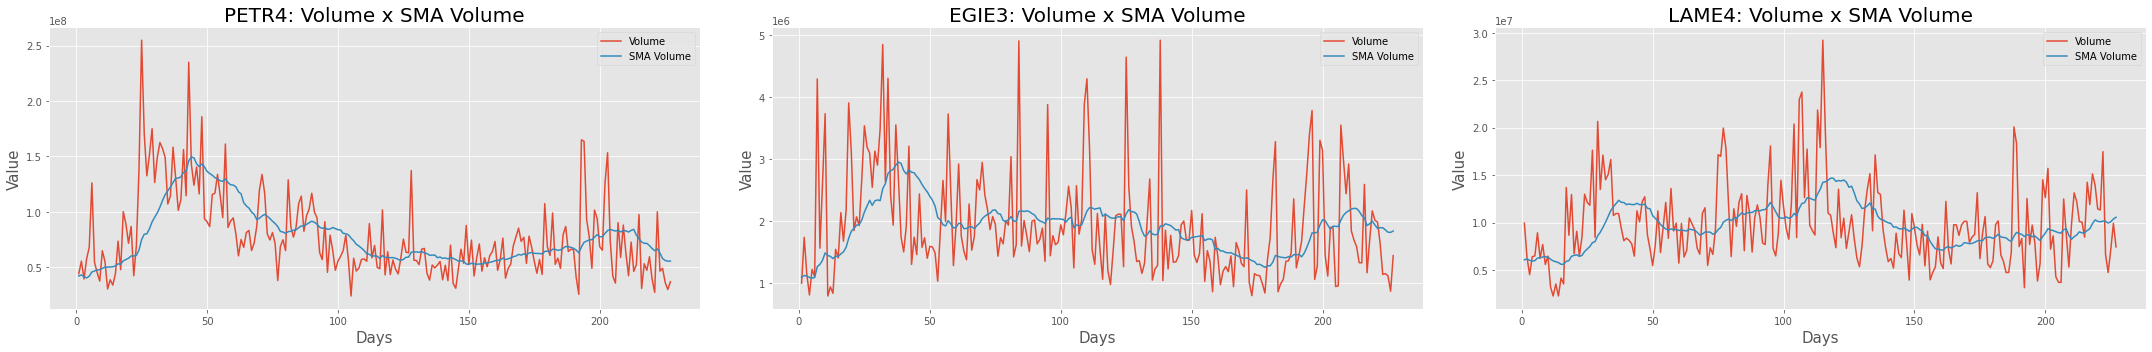

In [ ]:
# Volume X SMA21 Graphs from some stocks
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 5))
ax[0].plot(range(1, len(stocks_dataframe.loc[((stocks_dataframe.index.get_level_values(0)), 'PETR4.SA'), :][['Volume', 'SMA_Volume']])+1), stocks_dataframe.loc[((stocks_dataframe.index.get_level_values(0)), 'PETR4.SA'), 'Volume'], label='Volume')
ax[0].plot(range(1, len(stocks_dataframe.loc[((stocks_dataframe.index.get_level_values(0)), 'PETR4.SA'), :][['Volume', 'SMA_Volume']])+1), stocks_dataframe.loc[((stocks_dataframe.index.get_level_values(0)), 'PETR4.SA'), 'SMA_Volume'], label='SMA Volume') 
ax[0].set_title('PETR4: Volume x SMA Volume', fontsize=20)
ax[0].legend(loc = 'upper right')
ax[0].set_xlabel('Days', fontsize=15)
ax[0].set_ylabel('Value', fontsize=15)

ax[1].plot(range(1, len(stocks_dataframe.loc[((stocks_dataframe.index.get_level_values(0)), 'EGIE3.SA'), :][['Volume', 'SMA_Volume']])+1), stocks_dataframe.loc[((stocks_dataframe.index.get_level_values(0)), 'EGIE3.SA'), 'Volume'], label='Volume')
ax[1].plot(range(1, len(stocks_dataframe.loc[((stocks_dataframe.index.get_level_values(0)), 'EGIE3.SA'), :][['Volume', 'SMA_Volume']])+1), stocks_dataframe.loc[((stocks_dataframe.index.get_level_values(0)), 'EGIE3.SA'), 'SMA_Volume'], label='SMA Volume') 
ax[1].set_title('EGIE3: Volume x SMA Volume', fontsize=20)
ax[1].legend(loc = 'upper right')
ax[1].set_xlabel('Days', fontsize=15)
ax[1].set_ylabel('Value', fontsize=15)

ax[2].plot(range(1, len(stocks_dataframe.loc[((stocks_dataframe.index.get_level_values(0)), 'LAME4.SA'), :][['Volume', 'SMA_Volume']])+1), stocks_dataframe.loc[((stocks_dataframe.index.get_level_values(0)), 'LAME4.SA'), 'Volume'], label='Volume')
ax[2].plot(range(1, len(stocks_dataframe.loc[((stocks_dataframe.index.get_level_values(0)), 'LAME4.SA'), :][['Volume', 'SMA_Volume']])+1), stocks_dataframe.loc[((stocks_dataframe.index.get_level_values(0)), 'LAME4.SA'), 'SMA_Volume'], label='SMA Volume') 
ax[2].set_title('LAME4: Volume x SMA Volume', fontsize=20)
ax[2].legend(loc = 'upper right')
ax[2].set_xlabel('Days', fontsize=15)
ax[2].set_ylabel('Value', fontsize=15)
plt.tight_layout(w_pad=3)
plt.show();

## Modelling Data Frame

In [17]:
# Construct a list of stocks that the volume exceeds the sma volume for each day and store them in a list
volumes = []
sma_volumes = []
closes = []
assets = []
dates = []

for i in stocks_dataframe.index: # i turns out to be tuples, zeroth positions = date, first = ticker

  vol = round(stocks_dataframe.loc[(i[0], i[1]), 'Volume'], 2) # get all the volumes for each stock in the whole df and stores in vol variable
  volumes.append(vol)

  sma_vol = round(stocks_dataframe.loc[(i[0], i[1]), 'SMA_Volume'], 2) # Analogous as volume, keeps each sma vol in variable to further compare with volume
  sma_volumes.append(sma_vol)

  close = round(stocks_dataframe.loc[(i[0], i[1]), 'Adj Close'], 2)
  closes.append(close)

  assets.append(i[1])
  dates.append(i[0])

In [18]:
len(volumes), len(sma_volumes), len(closes), len(assets), len(dates)

(12712, 12712, 12712, 12712, 12712)

In [19]:
dataframe = pd.DataFrame()
dataframe['Date'] = dates
dataframe['assets'] = assets
dataframe['closes'] = closes
dataframe['volumes'] = volumes
dataframe['sma_volumes'] = sma_volumes
dataframe['vol-sma'] = dataframe['volumes'] - dataframe['sma_volumes'] # helpful column
dataframe.tail()

,Date,assets,closes,volumes,sma_volumes,vol-sma
12707,2020-12-30,TRPL4.SA,26.94,2488000.0,1270414.29,1217585.71
12708,2020-12-30,UGPA3.SA,23.20,3293700.0,5273323.81,-1979623.81
12709,2020-12-30,VALE3.SA,83.68,30102700.0,29787661.90,315038.10
12710,2020-12-30,VIVT3.SA,46.41,3998500.0,2731361.90,1267138.10
12711,2020-12-30,WEGE3.SA,75.40,6187700.0,5212514.29,975185.71


In [20]:
dataframe = dataframe.sort_values(['Date', 'vol-sma'], ascending=[True, False]) # Organize dataframe in descending vol-sma order and ascending date.

In [21]:
df = dataframe[['Date', 'assets', 'closes', 'vol-sma']]  # New df carrying only useful info
df.reset_index(inplace=True)
df.drop('index', axis = 1,inplace=True)
df

,Date,assets,closes,vol-sma
0,2020-01-30,ITUB4.SA,32.33,17282061.90
1,2020-01-30,MGLU3.SA,13.74,10462609.52
2,2020-01-30,BRFS3.SA,30.60,4567823.81
3,2020-01-30,WEGE3.SA,40.46,4059947.62
4,2020-01-30,LAME4.SA,27.48,3858100.00
...,...,...,...,...
12707,2020-12-30,BBAS3.SA,38.03,-7912509.52
12708,2020-12-30,ABEV3.SA,15.58,-11696147.62
12709,2020-12-30,MGLU3.SA,24.95,-13457914.29
12710,2020-12-30,BBDC4.SA,27.05,-17978161.90


In [22]:
df['dia'] = 1 # additional column will help dealing with how many days do the dataset has.
for i in range(0,12711):
  if (df.Date[i+1] != df.Date[i]):
    df.dia[i+1] = df.dia[i] + 1
  else:
    df.dia[i+1] = df.dia[i]
df

,Date,assets,closes,vol-sma,dia
0,2020-01-30,ITUB4.SA,32.33,17282061.90,1
1,2020-01-30,MGLU3.SA,13.74,10462609.52,1
2,2020-01-30,BRFS3.SA,30.60,4567823.81,1
3,2020-01-30,WEGE3.SA,40.46,4059947.62,1
4,2020-01-30,LAME4.SA,27.48,3858100.00,1
...,...,...,...,...,...
12707,2020-12-30,BBAS3.SA,38.03,-7912509.52,227
12708,2020-12-30,ABEV3.SA,15.58,-11696147.62,227
12709,2020-12-30,MGLU3.SA,24.95,-13457914.29,227
12710,2020-12-30,BBDC4.SA,27.05,-17978161.90,227


## Strategy Backtest Algo

###Slippage at your side (lucky) or good collocation 

In [44]:
rets1 = []
rets2 = []
closebuy = []
closesell = []
maxStocks = 10

for i in np.arange(0, 226, 1):
    buys = list(-df[df.dia == i+1]['closes'][:5].values + 0.01) # pays for it, so -
    stocksbought = list(df[df.dia == i+1]['assets'][:5].values)

    sells = list(df[df.dia == i+1].loc[::-1, 'closes'][:5].values + 0.01) # receives for short selling, so +
    stocksold = list(df[df.dia == i+1].loc[::-1, 'assets'][:5].values)
    print()
    print(f'L&S: Buy stocks {stocksbought} at close prices {buys}')
    print(f'L&S: Sell stocks {stocksold} at close prices {sells}')

    for l in stocksbought:
      close_buy = df[(df.dia == i+2) & (df.assets == l)]['closes'].values[0] + 0.01  # Sell stocks that have bought yesterday
      closebuy.append(close_buy)
    rr = sum(closebuy + buys) # financial cash on closing buys
    rets1.append(rr)
    print(f'L&S: Selling d-1 buys {stocksbought} at close prices {closebuy}')
    closebuy *= 0
    stocksbought *= 0

    for m in stocksold:
      close_sell = -df[(df.dia == i+2) & (df.assets == m)]['closes'].values[0] + 0.01  # Buy stocks that have sold yesterday
      closesell.append(close_sell)
    rrr = sum(closesell + sells) # financial cash on closing sells
    rets2.append(rrr)
    print(f'L&S: Buying d-1 sells {stocksold} at close prices {closesell}')
    closesell *= 0 
    stocksold *= 0


L&S: Buy stocks ['ITUB4.SA', 'MGLU3.SA', 'BRFS3.SA', 'WEGE3.SA', 'LAME4.SA'] at close prices [-32.32, -13.73, -30.59, -40.45, -27.47]
L&S: Sell stocks ['NTCO3.SA', 'BBDC4.SA', 'B3SA3.SA', 'GNDI3.SA', 'CSNA3.SA'] at close prices [48.96, 29.53, 47.199999999999996, 70.09, 13.39]
L&S: Selling d-1 buys ['ITUB4.SA', 'MGLU3.SA', 'BRFS3.SA', 'WEGE3.SA', 'LAME4.SA'] at close prices [31.73, 13.58, 30.560000000000002, 38.93, 27.330000000000002]
L&S: Buying d-1 sells ['NTCO3.SA', 'BBDC4.SA', 'B3SA3.SA', 'GNDI3.SA', 'CSNA3.SA'] at close prices [-47.57, -29.02, -46.6, -69.96, -12.86]

L&S: Buy stocks ['PETR4.SA', 'VALE3.SA', 'ABEV3.SA', 'ITSA4.SA', 'WEGE3.SA'] at close prices [-28.439999999999998, -46.160000000000004, -17.299999999999997, -12.3, -38.910000000000004]
L&S: Sell stocks ['NTCO3.SA', 'BBDC4.SA', 'CSNA3.SA', 'GGBR4.SA', 'ELET3.SA'] at close prices [47.589999999999996, 29.040000000000003, 12.879999999999999, 19.69, 33.57]
L&S: Selling d-1 buys ['PETR4.SA', 'VALE3.SA', 'ABEV3.SA', 'ITSA4.S

In [45]:
len(rets1), len(rets2) # obviously the last day was not included, as there wasn´t a 228th day to close the positions that would be opened on 227!

(226, 226)

In [27]:
datas = np.unique(df.Date)

In [29]:
datas.shape

(227,)

In [46]:
rets1 = np.array(rets1) # converting lists to arrays allows for a correct broadcasting. List sum would be a combination of ret1 and ret2!
rets2 = np.array(rets2)

In [47]:
ret_tot = rets1 + rets2
ret_tot.shape, datas[:-1].shape

((226,), (226,))

###Slippage against you (unlucky) or very bad collocation

In [49]:
rets1 = []
rets2 = []
closebuy = []
closesell = []
maxStocks = 10

for i in np.arange(0, 226, 1):
    buys = list(-df[df.dia == i+1]['closes'][:5].values - 0.005) # pays for it, so -
    stocksbought = list(df[df.dia == i+1]['assets'][:5].values)

    sells = list(df[df.dia == i+1].loc[::-1, 'closes'][:5].values - 0.005) # receives for short selling, so +
    stocksold = list(df[df.dia == i+1].loc[::-1, 'assets'][:5].values)
    print()
    print(f'L&S: Buy stocks {stocksbought} at close prices {buys}')
    print(f'L&S: Sell stocks {stocksold} at close prices {sells}')

    for l in stocksbought:
      close_buy = df[(df.dia == i+2) & (df.assets == l)]['closes'].values[0] - 0.005  # Sell stocks that have bought yesterday
      closebuy.append(close_buy)
    rr = sum(closebuy + buys) # financial cash on closing buys
    rets1.append(rr)
    print(f'L&S: Selling d-1 buys {stocksbought} at close prices {closebuy}')
    closebuy *= 0
    stocksbought *= 0

    for m in stocksold:
      close_sell = -df[(df.dia == i+2) & (df.assets == m)]['closes'].values[0] - 0.005  # Buy stocks that have sold yesterday
      closesell.append(close_sell)
    rrr = sum(closesell + sells) # financial cash on closing sells
    rets2.append(rrr)
    print(f'L&S: Buying d-1 sells {stocksold} at close prices {closesell}')
    closesell *= 0 
    stocksold *= 0


L&S: Buy stocks ['ITUB4.SA', 'MGLU3.SA', 'BRFS3.SA', 'WEGE3.SA', 'LAME4.SA'] at close prices [-32.335, -13.745000000000001, -30.605, -40.465, -27.485]
L&S: Sell stocks ['NTCO3.SA', 'BBDC4.SA', 'B3SA3.SA', 'GNDI3.SA', 'CSNA3.SA'] at close prices [48.945, 29.515, 47.184999999999995, 70.075, 13.375]
L&S: Selling d-1 buys ['ITUB4.SA', 'MGLU3.SA', 'BRFS3.SA', 'WEGE3.SA', 'LAME4.SA'] at close prices [31.715, 13.565, 30.545, 38.915, 27.315]
L&S: Buying d-1 sells ['NTCO3.SA', 'BBDC4.SA', 'B3SA3.SA', 'GNDI3.SA', 'CSNA3.SA'] at close prices [-47.585, -29.035, -46.615, -69.975, -12.875]

L&S: Buy stocks ['PETR4.SA', 'VALE3.SA', 'ABEV3.SA', 'ITSA4.SA', 'WEGE3.SA'] at close prices [-28.455, -46.175000000000004, -17.314999999999998, -12.315000000000001, -38.925000000000004]
L&S: Sell stocks ['NTCO3.SA', 'BBDC4.SA', 'CSNA3.SA', 'GGBR4.SA', 'ELET3.SA'] at close prices [47.574999999999996, 29.025000000000002, 12.864999999999998, 19.675, 33.555]
L&S: Selling d-1 buys ['PETR4.SA', 'VALE3.SA', 'ABEV3.SA'

In [50]:
rets1 = np.array(rets1) # converting lists to arrays allows for a correct broadcasting. List sum would be a combination of ret1 and ret2!
rets2 = np.array(rets2)

In [51]:
ret_tot_cont = rets1 + rets2
ret_tot_cont.shape, datas[:-1].shape

((226,), (226,))

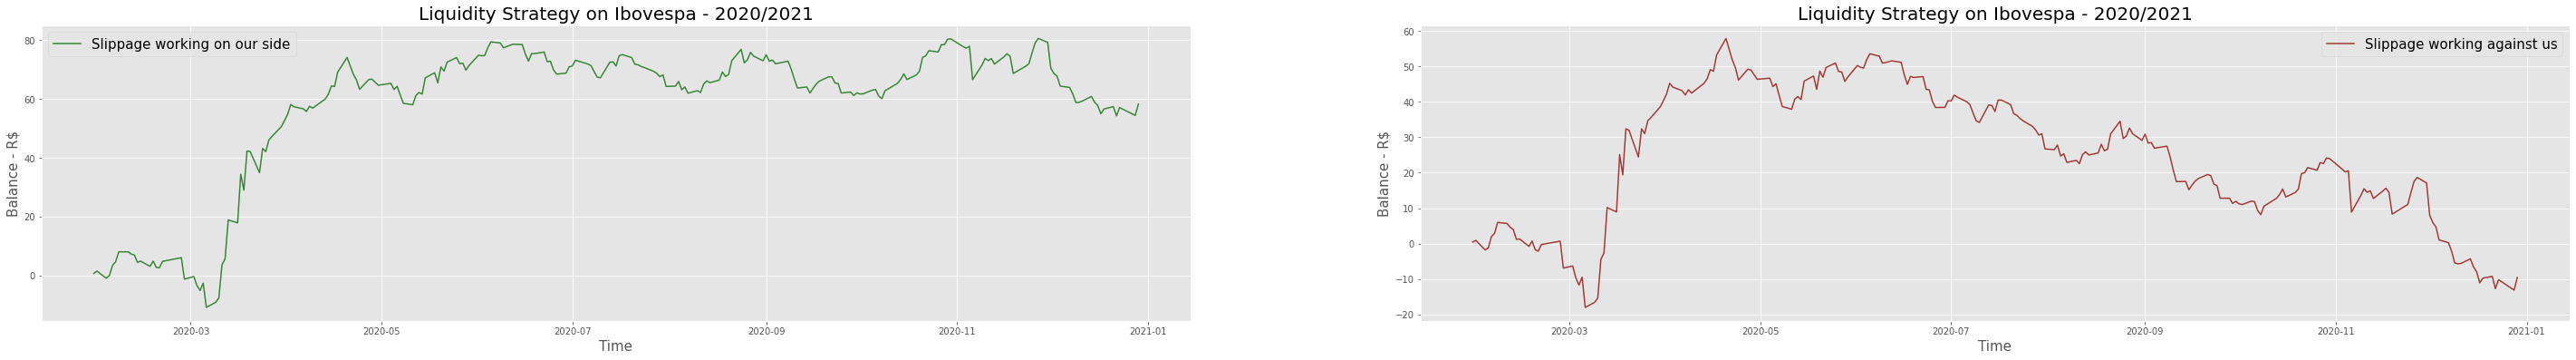

In [52]:
fig = plt.figure(figsize=(50, 6))
plt.subplot(1, 2, 1)
plt.plot(datas[:-1], ret_tot.cumsum(), color = 'darkgreen', alpha=.75, label = 'Slippage working on our side')
plt.title('Liquidity Strategy on Ibovespa - 2020/2021', fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('Balance - R$', fontsize=15)
plt.xlabel('Time', fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(datas[:-1], ret_tot_cont.cumsum(), color = 'darkred', alpha=.75, label = 'Slippage working against us')
plt.title('Liquidity Strategy on Ibovespa - 2020/2021', fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('Balance - R$', fontsize=15)
plt.xlabel('Time', fontsize=15);

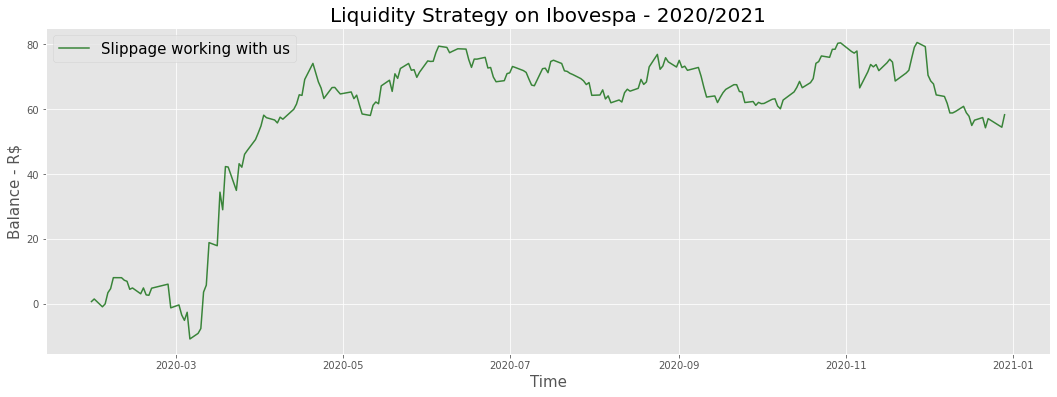

In [53]:
fig = plt.figure(figsize=(18, 6))
plt.plot(datas[:-1], ret_tot.cumsum(), color = 'darkgreen', alpha=.75, label = 'Slippage working with us')
plt.title('Liquidity Strategy on Ibovespa - 2020/2021', fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('Balance - R$', fontsize=15)
plt.xlabel('Time', fontsize=15);